# Lasso with ADMM

## Library

In [19]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import the data

In [20]:
path = './data/sample_data.csv'
data_df = pd.read_csv(path)

input_size = 5

X = data_df.iloc[:, :input_size].values
y = data_df.iloc[:, input_size:].values.reshape(-1,)

num_samples = X.shape[0]
num_train_samples = int(num_samples * 0.9)

rng = np.random.default_rng()
indices = rng.permutation(num_samples)
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

## Module

In [21]:
class ADMMLasso():
    def __init__(self):
        self.input_size = None
        self.w = None
        self.z = None
        self.gamma = None
        self._lambda = None
        self.rho = None
    
    def fit(self, X, y, max_iter=10000, p_thre=1e-5, s_thre=1e-5, 
            _lambda = 0.5, rho=0.5, verbose=False):
        X, y = self.__validate_input(X, y)
        self.__init_params(X, _lambda, rho)

        for iter in range(max_iter):
            next_w = self.__next_w(X, y)
            next_z = self.__next_z()
            next_gamma = self.__next_gamma()

            prev_w = self.w
            prev_z = self.z

            self.w = next_w
            self.z = next_z
            self.gamma = next_gamma

            if verbose and (iter + 1) % 10 == 0:
                loss = self.calc_loss(y, self.predict(X))
                print(f'step : {iter} loss : {loss}')

            if self.__converge(p_thre, s_thre, prev_w, prev_z):
                if verbose:
                    loss = self.calc_loss(y, self.predict(X))
                    print(f'step : {iter} loss : {loss}')
                    print(f'\t >> early stop!')
                break
        
        return self
    
    def predict(self, X):
        if X.shape[0] != self.input_size:
            X = X.T
        
        return X.T @ self.w
    
    def calc_loss(self, y, y_prime):
        right = np.sum((y - y_prime) ** 2) / 2
        mid = self._lambda * np.sum(np.abs(self.z))
        left = self.rho * np.sum((self.w - self.z) ** 2) / 2

        return right + mid + left

    def __validate_input(self, X, y):
        # X.shape should be (input_size, sample_nums)
        # y.shape should be (sample_nums, )
        if X.shape[0] == y.shape[0]:
            X = X.T
        else: assert(X.shape[1] != y.shape[0])

        return X, y
    
    def __init_params(self, X, _lambda, rho):
        self.input_size = X.shape[0]
        self.w = np.zeros((self.input_size))
        self.z = np.zeros_like(self.w)
        self.gamma = np.zeros_like(self.w)
        self._lambda = _lambda
        self.rho = rho

        return
    
    def __next_w(self, X, y):
        left = np.linalg.inv(X @ X.T + self.rho * np.eye(self.input_size))
        right = (X @ y).reshape(-1, )  - self.gamma + self.rho * self.z

        return left @ right

    def __next_z(self):
        next_z = np.zeros_like(self.z)

        for l in range(self.input_size):
            next_z[l] = self.__soft_threshold(
                _lambda=self._lambda / self.rho,
                x=self.w[l] + self.gamma[l] / self.rho)
        
        return next_z
    
    def __next_gamma(self):
        return self.gamma + self.rho * (self.w - self.z)

    def __soft_threshold(self, _lambda, x):
        return np.sign(x) * max((0, abs(x) - _lambda))
    
    def __converge(self, p_thre, s_thre, prev_w, prev_z):
        if np.sum((self.w - self.z) ** 2) > p_thre: return False
        if np.sum((self.w - prev_w) ** 2) > s_thre: return False
        if np.sum((self.z - prev_z) ** 2) > s_thre: return False

        return True

## Training

In [22]:
model = ADMMLasso()

model.fit(X_train, y_train, verbose=True)

step : 9 loss : 9.341902166154433
step : 19 loss : 2.255021008268465
step : 29 loss : 2.7116388445289528
step : 39 loss : 8.834901167554651
step : 49 loss : 2.268463321355474
step : 59 loss : 2.6672550814962657
step : 69 loss : 8.375737264441245
step : 79 loss : 2.2916752669988587
step : 89 loss : 2.623545746950768
step : 99 loss : 7.960132492356571
step : 109 loss : 2.3221816620009874
step : 119 loss : 2.5812573956942955
step : 129 loss : 7.58413435410971
step : 139 loss : 2.3580097431720812
step : 149 loss : 2.5409853500598443
step : 159 loss : 7.24410304989356
step : 169 loss : 2.397596381858737
step : 179 loss : 2.503187434429704
step : 189 loss : 6.93669650954558
step : 199 loss : 2.439711223594558
step : 209 loss : 2.468198748824161
step : 219 loss : 6.6587506946491875
step : 229 loss : 2.4833944444617946
step : 239 loss : 2.436838140769041
step : 249 loss : 6.403963337778016
step : 259 loss : 2.5279031887694616
step : 269 loss : 2.4102306179109174
step : 279 loss : 6.16835512462

## Test

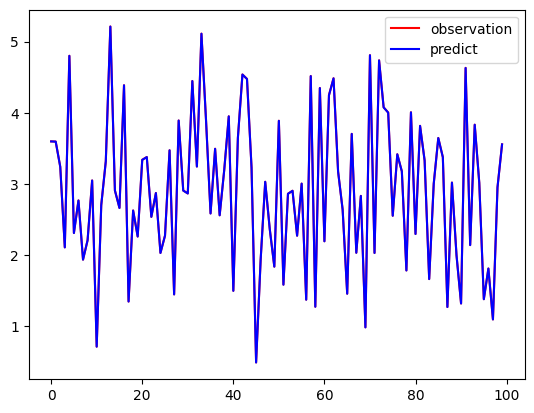

loss: 2.996342205517699 (0.02996342205517699 per each sample)


In [24]:
y_prime = model.predict(X_test)
loss = model.calc_loss(y_test, y_prime)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.plot(np.arange(y_test.shape[0]), y_test, color='red', label='observation')
ax.plot(np.arange(y_prime.shape[0]), y_prime, color='blue', label='predict')

ax.legend()
plt.show()
print(f'loss: {loss} ({loss / y_test.shape[0]} per each sample)')

## Consideration

In [25]:
print(model.w)

[9.99224122e-01 1.82298171e-06 1.99935810e+00 1.98423798e-06
 2.99944391e+00]


I generated $x_{0}, ..., x_{4}$ at random and computed $y$ by the following equation:

$$
y = x_{0} + 2x_{2} + 3x_{4}
$$

Thus, ${\bf w}$ should be ${[1, 0, 2, 0, 3]}^{\rm T}$. The result shows preferable performance.